# BAT.jl: Covid-19 Mortality Analysis

    Structure: 

    1. Global mortality analysis based on antibody tests.
        - see MPP repository.

    2. Country-based mortality estimates.
        2.1 Data Collection
        2.2 Likelihood definition
        2.3 MCMC Sampling (Single country, illustrative/debugging purpose)
        2.4 MCMC Sampling multiple countries
        2.5 Sampling results
        
    3. Conclusions
        - see MPP repository 
   
   
   
All the figures will be stored in the folder: `plots`

All the data files will be stored in the folder:`data` 

The recent data is fetched from [here](https://covid.ourworldindata.org/data/owid-covid-data.csv) every time the notebook is executed. 


In [1]:
using Tables, CSV, DataFrames, Dates, HTTP, TypedTables
using Query
using Distributions
using IntervalSets
using BAT
using ValueShapes
using ArraysOfArrays
using StatsBase
using LinearAlgebra
using Statistics
# using Plots
using PyPlot
using SpecialFunctions
using HCubature
using Dates
using Base.Threads
using LaTeXStrings
using PrettyTables

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 13
BIGGER_SIZE = 13

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Store separately figures and data files from different days 

dateoftoday = today()

PATH_1 = "../plots"
PATH_2 = "../data"

if !ispath(PATH_1); mkdir(PATH_1); end
if !ispath(PATH_2); mkdir(PATH_2); end

In [4]:
# Function to plot nice corner histograms

function corner_plots(smpl, dim_indices::AbstractArray, dim_names::AbstractArray;
        save_plot=false,
        FILE_NAME = "samples.pdf",
        N_bins = 40,
        levels_quantiles = [0.3, 0.7, 0.8, 0.9, 0.99, 1,], 
        hist_color = plt.cm.Blues(0.7), 
        colors = vcat([1 1 1 1], plt.cm.Blues(range(0, stop=1, length=length(levels_quantiles)))[2:end,:])
    )
    
    samples = flatview(unshaped.(smpl.v))
    sample_weights = smpl.weight
    
    samples_mode = mode(smpl)
    samples_mode = unshaped(samples_mode)
    
    N = length(dim_indices)
    bins=[] 
    fig, ax = plt.subplots(N,N, figsize=(11, 11))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    
    for idx in 1:N
        dim_idx = dim_indices[idx]
        bins_tmp = range(minimum(samples[dim_idx,:]), stop=maximum(samples[dim_idx,:]), length=N_bins)
        push!(bins, bins_tmp)
        ax[idx, idx].hist(samples[dim_idx,:], weights=sample_weights, bins=bins_tmp, color=hist_color)
        ax[idx, idx].axvline(samples_mode[dim_idx], c="red", label="Truth", alpha=1, lw=1, ls="--")
        ax[idx, idx].set_xlim(first(bins_tmp),last(bins_tmp))
    end
    
    for i in 2:N, j in 1:(i-1)
        dim_x = dim_indices[j]
        dim_y = dim_indices[i]
        histogram_2D = fit(Histogram, (samples[dim_x,:],samples[dim_y,:]), weights(sample_weights), (bins[j], bins[i]))
        histogram_2D = LinearAlgebra.normalize(histogram_2D, mode=:probability)
        
        levels=quantile([histogram_2D.weights...], levels_quantiles)
        
        ax[i,j].contourf(midpoints(histogram_2D.edges[1]), midpoints(histogram_2D.edges[2]), histogram_2D.weights', levels=levels, colors=colors)
        ax[i,j].axvline(samples_mode[dim_x], c="red", label="Truth", alpha=1, lw=1, ls="--")
        ax[i,j].axhline(samples_mode[dim_y], c="red", label="Truth", alpha=1, lw=1, ls="--")
        ax[i,j].set_xlim(first(bins[j]),last(bins[j]))
        ax[i,j].set_ylim(first(bins[i]),last(bins[i]))
        ax[j,i].set_visible(false)
        
    end
    
    for i in 1:N, j in 1:N
        if i < N 
            ax[i,j].get_xaxis().set_visible(false)
        else
            ax[i,j].set_xlabel(dim_names[j])
        end
        
        if j == i || j>1
           ax[i,j].get_yaxis().set_visible(false) 
        else
            ax[i,j].set_ylabel(dim_names[i])
        end
    end
    
    if save_plot 
        fig.savefig(FILE_NAME, bbox_inches = "tight")
    end
        
end

corner_plots (generic function with 1 method)

# 1. Global mortality analysis based on antibody tests

    - See MPP repository

# 2. Country-based mortality estimates

## 2.1 Data Collection

In [5]:
# open(PATH_2*"owid-covid-data.csv", "w") do io
#     content = HTTP.get("https://covid.ourworldindata.org/data/owid-covid-data.csv").body
#     write(io, content)
#     nothing
# end

# df = CSV.read(PATH_2*"owid-covid-data.csv", copycols = true, pool = true);

df = CSV.read("../data/owid-covid-data.csv", copycols = true, pool = true)

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths
,String?,String,Date,Int64,Int64,Int64,Int64
1,ABW,Aruba,2020-03-13,2,2,0,0
2,ABW,Aruba,2020-03-20,4,2,0,0
3,ABW,Aruba,2020-03-24,12,8,0,0
4,ABW,Aruba,2020-03-25,17,5,0,0
5,ABW,Aruba,2020-03-26,19,2,0,0
6,ABW,Aruba,2020-03-27,28,9,0,0
7,ABW,Aruba,2020-03-28,28,0,0,0
8,ABW,Aruba,2020-03-29,28,0,0,0
9,ABW,Aruba,2020-03-30,50,22,0,0


In [6]:
# countries_of_interest = ["NOR", "POL", "AUT", "JPN", "SWE", "CHL", "SAU", "ROU", 
#     "IND", "IRN", "PAK", "SGP", "USA", "ITA", "GBR", "DEU", "RUS", "FRA", "TUR", "BRA", 
#     "CAN", "BEL", "PER", "NLD", "CHE", "ISR", "CHN", "UKR"]; # First Example


countries_of_interest = ["ESP", "DNK", "FIN", "FRA", "GBR", "POL", "ITA", "JPN",
    "NLD", "ROU", "SWE", "USA", "AUT", "BEL", "CAN", "CHE", "CHN", "DEU", "TUR", "HUN",];


population = Dict("ESP"=>46754778, "DNK"=>5792000, "FIN"=>5540720, "FRA"=>65273511, 
    "GBR"=>67886911, "POL"=>37846611, "ITA"=>60461826, "JPN"=>126476461, 
    "NLD"=>17134872, "ROU"=>19254711, "SWE"=>10099265, "USA"=>331002000, "AUT"=>9006000, 
    "BEL"=>11589000, "CAN"=>37742000, "CHE"=>8654622, "CHN"=>1439323776, "DEU"=>83783942, "TUR"=>84207771, "HUN"=>9663457);

# Removed: AUS , KOR, ISR , NOR
# "RUS"=>145925759,
# "IND"=>1378085450, 
# "MEX"=>128740662, 
# "BRA"=>212343834,
# "IDN"=>273113362, 

In [7]:
by_country = @from x in df begin
    @where x.iso_code in countries_of_interest
    @group x by x.iso_code into g
    @select key(g) => DataFrame({g.date, g.new_cases, g.new_deaths, g.location})
    @collect Dict
end;

In [8]:
# Date of the last update: 

most_recent_update_date = maximum(by_country["USA"].date)

@show most_recent_update_date

most_recent_update_date = 2020-05-15


2020-05-15

## 2.2 Likelihood definition

   
Parameters: 

   - Death Delay (`death_delay`): number of days between positive test result and death. 
   - Delay spread (`delay_spread`): the spread of death distribution. 
   - Death fraction (`death_fraction`): a fraction of those who died. 
   - Death fluctuations (`death_fluct`): fluctuation coefficient per day. 
   
   
Let us assume that in the day `i` $N_i$ people got infected. This will lead to 

$n_i = N_i$*`death_fraction` 

death in the future. Let us also assume that these deaths will be distributed according to the Normal distribution 

$n_i \cdot$`Normal(mu = i+death_delay; sigma = delay_spread)`

We can predict total death distribution by summing up death distributions over all days `i=1:D` 

$\sum_{i=1:D} n_i \cdot$`Normal(mu = i+death_delay; sigma = delay_spread)`

and compare to the true death distribution assuming the presence of normal fluctuations with sigma=`death_fluct*sqrt(deth_per_day)`

Let us define a model function:

In [9]:
```
Normal distribution 
```
function model_1(params::NT, new_cases::AA) where {NT<:NamedTuple, AA<:AbstractArray}

    days_bins = collect(Base.OneTo(length(new_cases)+1))
    predicted_deaths = zeros(length(new_cases))
        
    for (day,new_cases_per_day) in enumerate(new_cases)
        death_per_day = cdf.(truncated(Normal(day + params.death_delay, params.delay_spread), day - 1, Inf), days_bins)
        death_per_day =  (death_per_day[2:end] .- death_per_day[1:end-1]) .* new_cases_per_day*params.death_fraction
        predicted_deaths .= predicted_deaths .+ death_per_day
    end

    return predicted_deaths
end

```
Log-Normal distribution 
```
function model_2(params::NT, new_cases::AA) where {NT<:NamedTuple, AA<:AbstractArray}

    predicted_deaths = zeros(length(new_cases)+40)
        
    for (day,new_cases_per_day) in enumerate(new_cases)
        
        days_range = collect(1:1:32)
        mu_r = log(params.death_delay) - params.delay_spread^2 / 2.0
        distribution = truncated(LogNormal(mu_r, params.delay_spread), 0, 30)
        death_per_day = cdf.(distribution, days_range)
        death_per_day =  (death_per_day[2:end] .- death_per_day[1:end-1]) .* new_cases_per_day*params.death_fraction
        predicted_deaths[day:day+30] .= predicted_deaths[day:day+30] .+ death_per_day
    end

    return predicted_deaths[1:length(new_cases)]
end

model_2 (generic function with 1 method)

In [10]:
function log_likelihood(params; new_cases = country_new_cases, new_deaths = country_new_deaths, model=model_1)
    predicted_deaths = model(params, new_cases);
#     probs = pdf.(truncated.(Normal.(predicted_deaths, 2 .+ params.death_fluct .* sqrt.(predicted_deaths)), 0, Inf), new_deaths)
    probs = pdf.(Normal.(predicted_deaths, 2 .+ params.death_fluct .* sqrt.(predicted_deaths)), new_deaths)
    return LogDVal(sum(log.(probs)))
end

function log_likelihood_constructor(new_cases, new_deaths;  model=model_1)
    return x -> log_likelihood(x, new_cases=new_cases, new_deaths=new_deaths, model=model)
end

log_likelihood_constructor (generic function with 1 method)

In [11]:
prior = NamedTupleDist(
        death_delay = 0. .. 20.,
        delay_spread = 0.0 .. 15.,
        death_fraction = 0. .. 0.3,
        death_fluct = 0. .. 30.,
    );

In [12]:
algorithm = MetropolisHastings()

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 1000,
    max_nsteps_per_cycle = 5000,
    max_time_per_cycle = 80,
    max_ncycles = 40
)

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.1..0.15,
    β = 1.5,
    c = 1e-4..1e2
)

nchains = 5
nsamples = 10^5;

## 2.3 MCMC Sampling (Single country, illustrative/debugging purpose)

In [13]:
# Let us consider Germany:

name_tmp = "DEU"

@show name_tmp

country_dates = by_country[name_tmp].date 
country_new_cases =  by_country[name_tmp].new_cases 
# country_new_cases[argmin(country_new_cases)] = 0
country_new_deaths = by_country[name_tmp].new_deaths


ind_dates = collect(Base.OneTo(length(country_new_cases)));

name_tmp = "DEU"


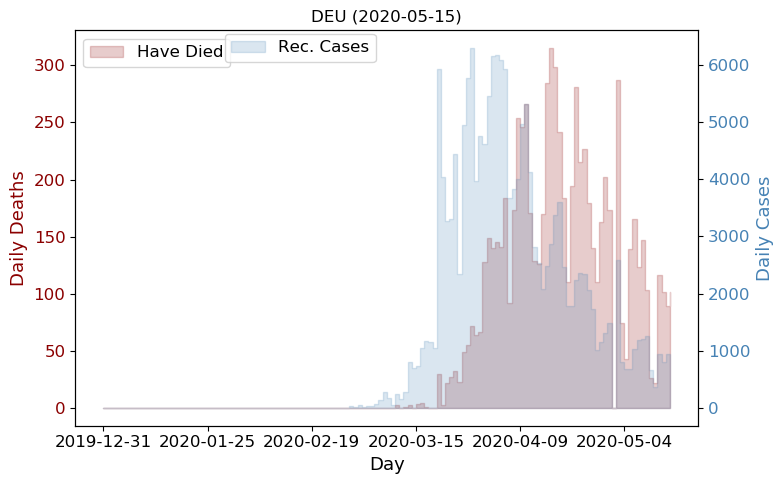

In [14]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 5))

color = "darkred"
ax1.set_xlabel("Day")
ax1.set_ylabel("Daily Deaths", color=color)
ax1.fill_between(ind_dates, country_new_deaths, step="post", color="darkred", lw=1, alpha=0.2, label="Have Died")
ax1.tick_params(axis="y", labelcolor=color)
ax1.legend(loc="upper left", frameon=true, framealpha=0.8, ncol=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "steelblue"
ax2.set_ylabel("Daily Cases", color=color,)  # we already handled the x-label with ax1
ax2.fill_between(ind_dates, country_new_cases, step="post", color=color, alpha=0.2,  lw=1, label = "Rec. Cases")
# ax2.step(ind_dates, country_new_cases, color=color, alpha=0.5,  lw=1)
ax2.tick_params(axis="y", labelcolor=color)

# plt.fill_between(x,y, step="pre", alpha=0.4)

ax1.set_title(name_tmp*" ($most_recent_update_date)")

ax1.set_xticks(ind_dates[1:25:end])
ax1.set_xticklabels(country_dates[ind_dates[1:25:end]], minor=false, rotation=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.legend(loc=(0.24, 0.92), frameon=true, framealpha=0.8, ncol=1)
plt.show()

# fig.savefig(PATH_1*"fig-4.pdf", bbox_inches = "tight")

In [15]:
posterior = PosteriorDensity(log_likelihood_constructor(country_new_cases, country_new_deaths, model=model_1), prior);

@time samples_deu, stats_deu = bat_sample(posterior, (nsamples, nchains), 
    algorithm, burnin=burnin, max_time = 30);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 5 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 5 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 5 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 5 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 5 chains, 1 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 67.061855 seconds (195.76 M allocations: 173.050 GiB, 45.23% gc time)


In [16]:
size(samples_deu)

(34795,)

In [17]:
mode_deu = mode(samples_deu)[1]

# mode_deu = mode(samples_deu)
# mode_deu = bat_findmode(posterior, initial_mode = mode_deu).result[]

println("Mode: $mode_deu")
println("Stddev: $(std(samples_deu))")

Mode: (death_delay = 13.511074699952001, delay_spread = 0.8695683061781865, death_fraction = 0.04852250067469309, death_fluct = 4.086074810346271)
Stddev: ShapedAsNT((death_delay = 0.3973910212221822, delay_spread = 0.6240688436264925, death_fraction = 0.0024357963870071824, death_fluct = 0.396995566322565))


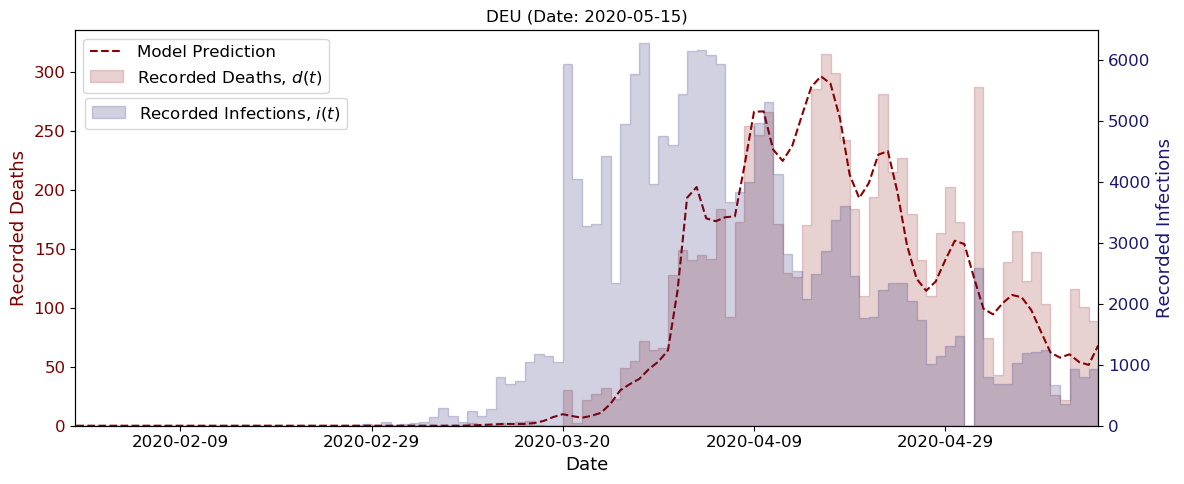

In [18]:
fig, ax1 = plt.subplots(1,1, figsize=(12, 5))

color = "maroon"
ax1.set_xlabel("Date")
ax1.set_ylabel("Recorded Deaths", color=color)
ax1.fill_between(ind_dates, country_new_deaths, step="post", color="maroon", lw=1, alpha=0.18, label=L"Recorded Deaths, $d(t)$")
ax1.plot(ind_dates, model_1(mode_deu, country_new_cases), color="darkred", ls="--", lw=1.5, label="Model Prediction")
ax1.tick_params(axis="y", labelcolor=color)
ax1.legend(loc="upper left", frameon=true, framealpha=0.8, ncol=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "midnightblue"
ax2.set_ylabel("Recorded Infections", color=color,)  # we already handled the x-label with ax1
ax2.fill_between(ind_dates, country_new_cases, step="post", color=color, alpha=0.2,  lw=1, label = L"Recorded Infections, $i(t)$")
# ax2.step(ind_dates, country_new_cases, color=color, alpha=0.5,  lw=1)
ax2.tick_params(axis="y", labelcolor=color)

# plt.fill_between(x,y, step="pre", alpha=0.4)

ax1.set_title(name_tmp*" (Date: $most_recent_update_date)")

ax1.set_xticks(ind_dates[1:20:end])
ax1.set_xticklabels(country_dates[ind_dates[1:20:end]], minor=false, rotation=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.legend(loc=(0.01, 0.75), frameon=true, framealpha=0.8, ncol=1)

ax1.set_xlim(30, length(country_dates));
ax1.set_ylim(0, maximum(country_new_deaths)+20);
ax2.set_ylim(0, maximum(country_new_cases)+200);

plt.show()

fig.savefig(PATH_1*"fig-4.pdf", bbox_inches = "tight")

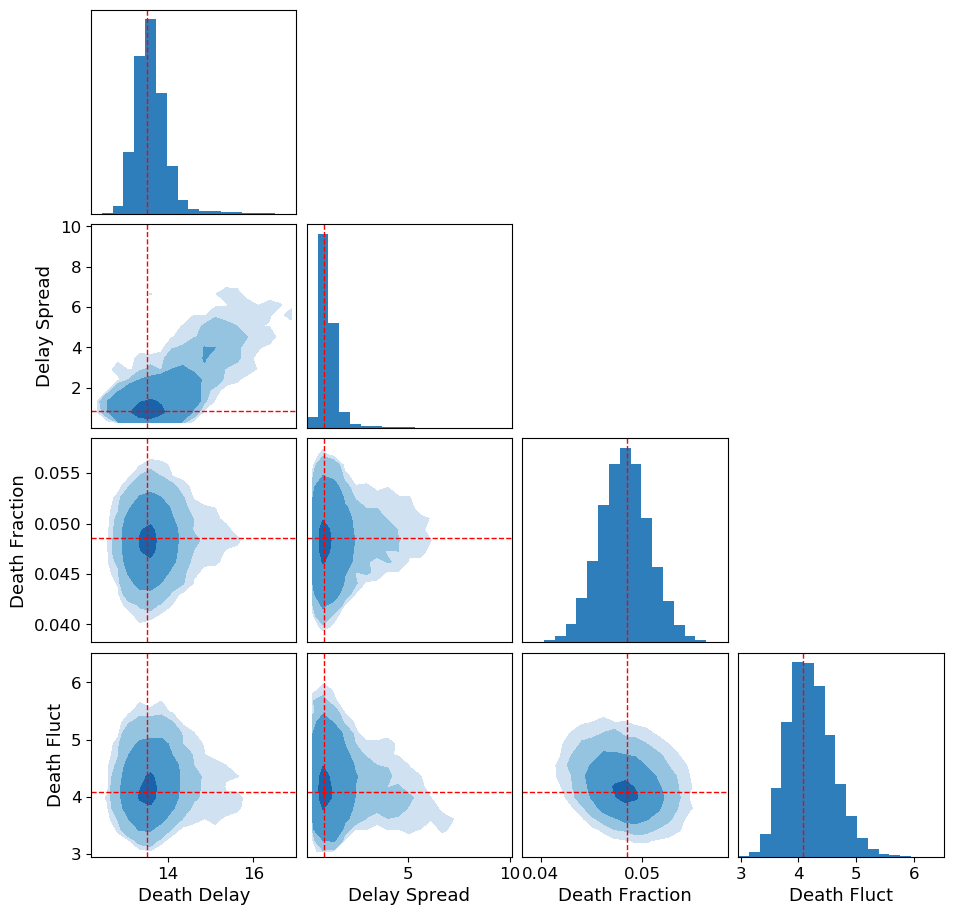

In [19]:
corner_plots(samples_deu, [1,2,3,4], ["Death Delay", "Delay Spread", "Death Fraction", "Death Fluct"], N_bins=20, 
    save_plot=false,
    FILE_NAME = PATH_1*"fig-5.pdf",) #levels_quantiles = [ 0.7, 0.9, 0.99, 1,],

# corner_plots(samples_deu, [1,2,3,4], ["Death Delay", "Delay Spread", "Death Fraction", "Death Fluct"], levels_quantiles = [ 0.7, 0.9, 0.99, 1,], N_bins=20, 
#     save_plot=true,
#     FILE_NAME = PATH_1*"fig-5.pdf",)

## 2.4 MCMC Sampling multiple countries

In [20]:
modes_of_countries = DataFrame(
    country_name = String[],
    death_delay_std=Float64[],
    delay_spread_std=Float64[], 
    death_fraction_std=Float64[],
    death_fluct_std=Float64[],
    death_delay=Float64[],
    delay_spread=Float64[],
    death_fraction=Float64[],
    death_fluct=Float64[],
    death_delay_samples = Array[],
    delay_spread_samples = Array[],
    death_fraction_samples = Array[],
    mcmc_weights = Array[],
)

for country in countries_of_interest
    @show country
    
    if country == "CHN"
        # dataset contains a strange bump
        posterior = PosteriorDensity(log_likelihood_constructor(by_country[country].new_cases[1:100] , by_country[country].new_deaths[1:100] , model=model_1), prior) 
    elseif country == "ESP"
        #problematic data-point:
        nc_tmp = by_country[country].new_cases
        nc_tmp[argmin(nc_tmp)] = 0
        nc_tmp[argmin(nc_tmp)] = 0
        nd_tmp = by_country[country].new_deaths
        nd_tmp[argmin(nd_tmp)] = 0
        posterior = PosteriorDensity(log_likelihood_constructor(nc_tmp, nd_tmp, model=model_1), prior) # dataset contains a strange bump
    elseif country == "DNK"
        #problematic data-point:
        nc_tmp = by_country[country].new_deaths
        nc_tmp[argmin(nc_tmp)] = 0
        posterior = PosteriorDensity(log_likelihood_constructor(by_country[country].new_cases, nc_tmp, model=model_1), prior) # dataset contains a strange bump
    elseif  country ==  "GBR"
         #problematic data-point:
        nc_tmp = by_country[country].new_cases
        nc_tmp[argmin(nc_tmp)] = 0
        posterior = PosteriorDensity(log_likelihood_constructor(nc_tmp, by_country[country].new_deaths, model=model_1), prior) # dataset contains a strange bump
    else
        posterior = PosteriorDensity(log_likelihood_constructor(by_country[country].new_cases , by_country[country].new_deaths, model=model_1), prior)
    end
    @time samples_run, stats_run = bat_sample(posterior, (10^3, 4), algorithm, burnin=burnin, max_time = 70)
    mode_run = mode(samples_run)[1]
    params_tmp = [country, append!(unshaped(std(samples_run)), values(mode_run))...]
    
    smpl = flatview(unshaped.(samples_run.v))
    
    push!(modes_of_countries,[params_tmp..., smpl[1,:], smpl[2,:],smpl[3,:], samples_run.weight])
end

# CSV.write(PATH_2*"mcmc_data.csv", modes_of_countries)

# modes_of_countries = CSV.read(PATH_2*"mcmc_data.csv", copycols = true, pool = true);

country = "ESP"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 22.122371 seconds (67.82 M allocations: 70.520 GiB, 54.23% gc time)
country = "DNK"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 2 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 18.650182 seconds (52.31 M allocations: 56.270 GiB, 51.59% gc time)
country = "FIN"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 23.009194 seconds (69.42 M allocations: 75.031 GiB, 55.29% gc time)
country = "FRA"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 19.822808 seconds (60.51 M allocations: 66.236 GiB, 57.03% gc time)
country = "GBR"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 19.039573 seconds (60.62 M allocations: 65.386 GiB, 57.92% gc time)
country = "POL"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 1 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

  7.221049 seconds (29.61 M allocations: 16.747 GiB, 48.08% gc time)
country = "ITA"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 22.352549 seconds (61.60 M allocations: 67.595 GiB, 53.32% gc time)
country = "JPN"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 26.984982 seconds (72.13 M allocations: 78.279 GiB, 54.06% gc time)
country = "NLD"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 22.187841 seconds (66.72 M allocations: 72.542 GiB, 55.53% gc time)
country = "ROU"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 17.023601 seconds (48.68 M allocations: 49.200 GiB, 50.40% gc time)
country = "SWE"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 88.072525 seconds (263.56 M allocations: 288.285 GiB, 55.65% gc time)
country = "USA"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 40.088341 seconds (109.93 M allocations: 119.459 GiB, 56.00% gc time)
country = "AUT"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 1 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 21.550370 seconds (53.15 M allocations: 57.870 GiB, 48.29% gc time)
country = "BEL"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 19.597058 seconds (52.07 M allocations: 56.496 GiB, 52.77% gc time)
country = "CAN"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 18.649777 seconds (50.05 M allocations: 54.690 GiB, 51.03% gc time)
country = "CHE"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 17.421942 seconds (49.84 M allocations: 53.882 GiB, 51.53% gc time)
country = "CHN"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 1 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 15.588718 seconds (52.80 M allocations: 40.523 GiB, 46.40% gc time)
country = "DEU"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

 24.061770 seconds (61.83 M allocations: 67.308 GiB, 50.62% gc time)
country = "TUR"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

  8.644779 seconds (42.60 M allocations: 21.870 GiB, 46.28% gc time)
country = "HUN"


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 1 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

  5.305874 seconds (27.05 M allocations: 14.879 GiB, 46.27% gc time)


## 2.5 Sampling results:

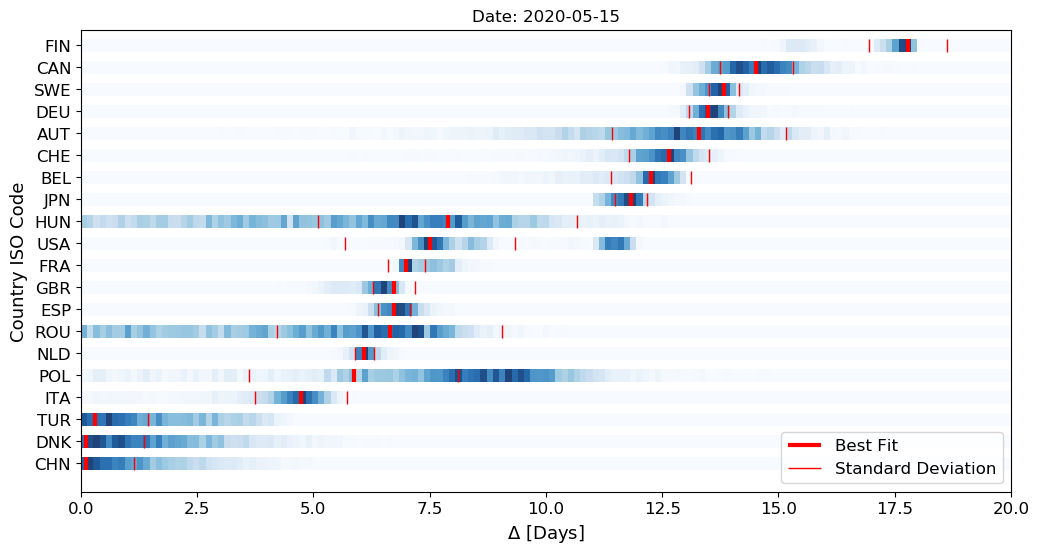

In [21]:
ind_sorted = sortperm(modes_of_countries.death_delay, rev=false)
ind_dates = collect(Base.OneTo(length(modes_of_countries[:,1])))

width = 0.6

label_1 = "Best Fit"
label_2 = "Standard Deviation"

fig, ax = plt.subplots(1,1, sharex=true, figsize=(12, 6))
fig.subplots_adjust(hspace=0.0, wspace=0.00)

for (ind, c_name) in enumerate(ind_sorted)
    
    bins_range = collect(range(0, stop=20, length=150))
    
    histogram_2D = fit(Histogram, modes_of_countries[c_name,:].death_delay_samples, weights(modes_of_countries[c_name,:].mcmc_weights),  bins_range)
    histogram_2D = LinearAlgebra.normalize(histogram_2D, mode=:probability)
    
    edges = collect(histogram_2D.edges[1])
    h_weights = histogram_2D.weights ./ maximum(histogram_2D.weights)
    
    for i in Base.OneTo(length(h_weights))
    
        r1 = matplotlib.patches.Rectangle([edges[i], ind], edges[i+1] - edges[i], width, fill=true, linewidth=0, color=plt.cm.Blues(h_weights[i]), alpha=0.9) 
        ax.add_patch(r1)
        
    end
    
    # MCMC Mode + std  
    ax.vlines(modes_of_countries[c_name,:].death_delay, ind, ind+width, colors="red", alpha=1, lw=3, label=label_1)
    ax.vlines(modes_of_countries[c_name,:].death_delay + modes_of_countries[c_name,:].death_delay_std, ind, ind+width, alpha=1, lw=1, ls="-", colors="red", label=label_2)
    ax.vlines(modes_of_countries[c_name,:].death_delay - modes_of_countries[c_name,:].death_delay_std, ind, ind+width, alpha=1, lw=1, ls="-", colors="red")

      # MCMC 50% quantile 
#     ax.vlines(quantile(modes_of_countries[c_name,:].death_delay_samples, weights(modes_of_countries[c_name,:].mcmc_weights),  0.5), ind, ind+width, colors="red", alpha=1, lw=3,)
#     ax.vlines(quantile(modes_of_countries[c_name,:].death_delay_samples, weights(modes_of_countries[c_name,:].mcmc_weights),  0.975), ind, ind+width, alpha=1, lw=1, ls="-", colors="red")
#     ax.vlines(quantile(modes_of_countries[c_name,:].death_delay_samples, weights(modes_of_countries[c_name,:].mcmc_weights),  0.025), ind, ind+width, alpha=1, lw=1, ls="-", colors="red")
    
    label_1 = "_nolegend_"
    label_2 = "_nolegend_"
end

ax.legend(loc="lower right", frameon=true, framealpha=0.8, ncol=1)

ax.set_yticks(ind_dates .+ width/2)
ax.set_yticklabels(modes_of_countries[ind_sorted,1], minor=false, rotation=0)

# ax.xticks(ind_dates, modes_of_countries[:,1])

ax.set_xlim(0, 20);
ax.set_ylim(0, length(modes_of_countries[:,1])+1)

ax.set_title("Date: $most_recent_update_date")

ax.set_ylabel("Country ISO Code", )
ax.set_xlabel(L"$\Delta$ [Days]",)

fig.savefig(PATH_1*"fig-6.pdf", bbox_inches = "tight")

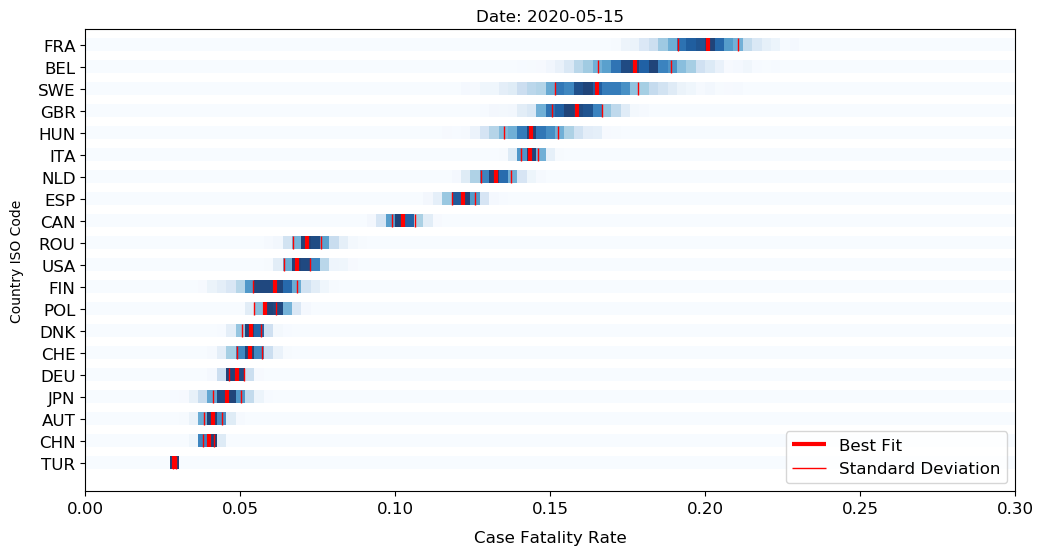

In [22]:
ind_sorted = sortperm(modes_of_countries.death_fraction, rev=false)
ind_dates = collect(Base.OneTo(length(modes_of_countries[:,1])))

width = 0.6

label_1 = "Best Fit"
label_2 = "Standard Deviation"

fig, ax = plt.subplots(1,1, sharex=true, figsize=(12, 6))
fig.subplots_adjust(hspace=0.0, wspace=0.00)

for (ind, c_name) in enumerate(ind_sorted)
    bins_range = collect(range(0, stop=0.3, length=100))
    histogram_2D = fit(Histogram, modes_of_countries[c_name,:].death_fraction_samples, weights(modes_of_countries[c_name,:].mcmc_weights),  bins_range)
    histogram_2D = LinearAlgebra.normalize(histogram_2D, mode=:probability)
    
    edges = collect(histogram_2D.edges[1])
    h_weights = histogram_2D.weights ./ maximum(histogram_2D.weights)
    
    for i in Base.OneTo(length(h_weights))
    
        r1 = matplotlib.patches.Rectangle([edges[i], ind], edges[i+1] - edges[i], width, fill=true, linewidth=0, color=plt.cm.Blues(h_weights[i]), alpha=0.9) 
        ax.add_patch(r1)
        
    end
    
    ax.vlines(modes_of_countries[c_name,:].death_fraction, ind, ind+width, colors="red", alpha=1, lw=3, label=label_1)
    ax.vlines(modes_of_countries[c_name,:].death_fraction + modes_of_countries[c_name,:].death_fraction_std, ind, ind+width, alpha=1, lw=1, ls="-", colors="red", label=label_2)
    ax.vlines(modes_of_countries[c_name,:].death_fraction - modes_of_countries[c_name,:].death_fraction_std, ind, ind+width, alpha=1, lw=1, ls="-", colors="red")
        
    label_1 = "_nolegend_"
    label_2 = "_nolegend_"
    
end

ax.legend(loc="lower right", frameon=true, framealpha=0.8, ncol=1)

ax.set_yticks(ind_dates .+ width/2)
ax.set_yticklabels(modes_of_countries[ind_sorted,1], minor=false, rotation=0)

ax.set_xlim(0, 0.3);
ax.set_ylim(0, length(modes_of_countries[:,1])+1)

ax.set_title("Date: $most_recent_update_date")

ax.set_ylabel("Country ISO Code", labelpad=10,  size=10)
ax.set_xlabel("Case Fatality Rate", labelpad=10,  size=12)

fig.savefig(PATH_1*"fig-7.pdf", bbox_inches = "tight")

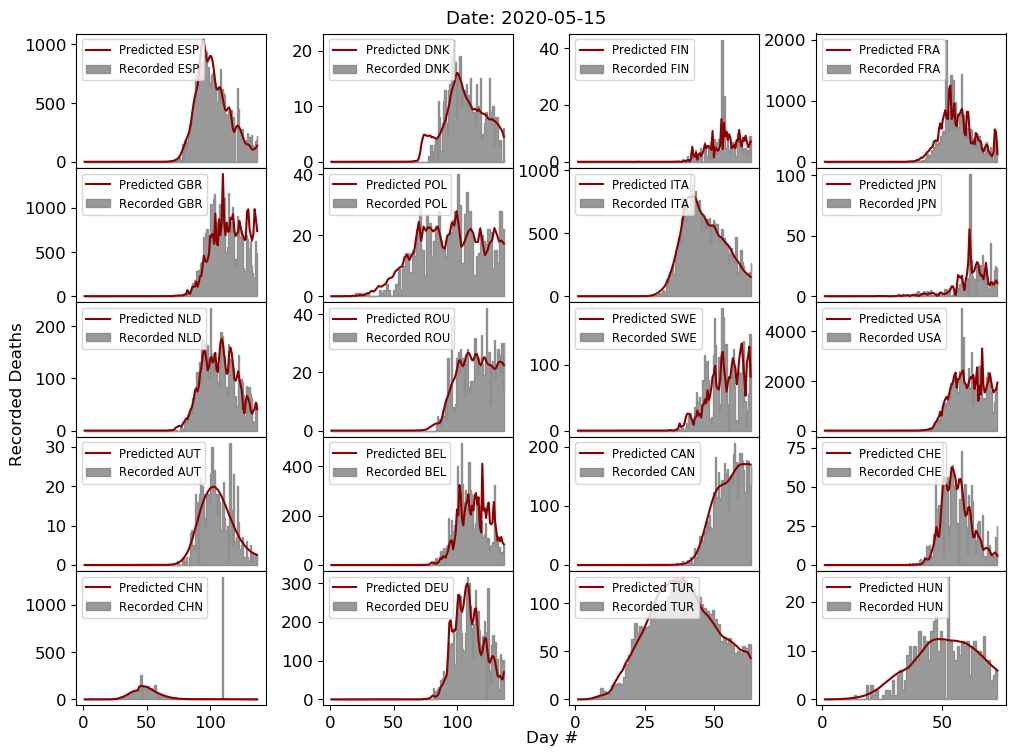

In [23]:
N = 5
M = 4
parshapes = varshape(posterior)
fig, ax = plt.subplots(N,M, figsize=(12, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.3, top=0.95)

for t in 1:N*M
    
    if t > length(modes_of_countries[:,1])
        break
    end
    
    i = mod1(t,M)
    j = cld(t,M)
    
    modes_of_countries_tmp = modes_of_countries[t,:]
    country_new_deaths = by_country[modes_of_countries_tmp.country_name].new_deaths
    ind_dates = collect(Base.OneTo(length(country_new_deaths)))
    country_prediction = model_1(parshapes([modes_of_countries_tmp[6:9]...])[1], by_country[modes_of_countries_tmp.country_name].new_cases )

    ax[j,i].fill_between(ind_dates, country_new_deaths, step="post", color="gray", lw=1, alpha=0.8, label="Recorded $(modes_of_countries_tmp.country_name)")
    ax[j,i].plot(ind_dates, country_prediction, color="darkred", ls="-", lw=1.5, label="Predicted $(modes_of_countries_tmp.country_name)")
    ax[j,i].legend(loc="upper left", frameon=true, framealpha=0.8, ncol=1, fontsize = "x-small")

end

# fig.suptitle("Death Prediction vs. Truth ($most_recent_update_date)", size=16)
fig.suptitle("Date: $most_recent_update_date")
fig.text(0.07, 0.5, "Recorded Deaths", va="center", rotation="vertical",)
fig.text(0.5, 0.07, "Day #", va="center", rotation="horizontal",)

fig.savefig(PATH_1*"fig-8.pdf", bbox_inches = "tight")

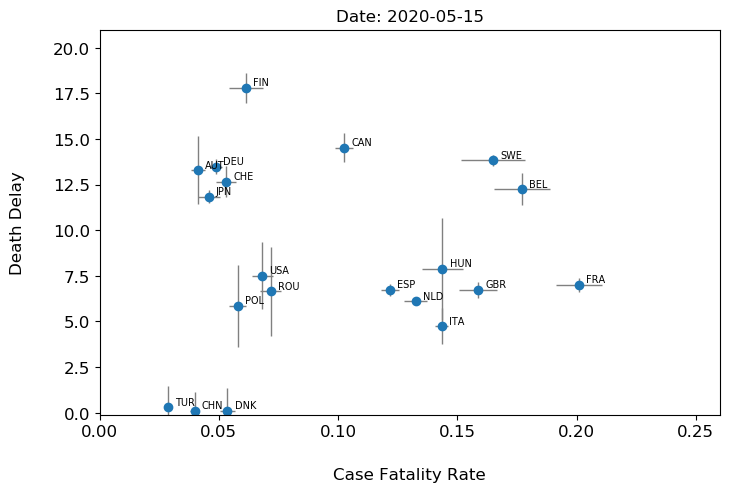

In [24]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))

# ax.scatter(modes_of_countries.death_fraction, modes_of_countries.death_delay)

ax.errorbar(modes_of_countries.death_fraction, modes_of_countries.death_delay, yerr=modes_of_countries.death_delay_std, xerr=modes_of_countries.death_fraction_std, 
    fmt="o", color="C0", ecolor="gray", alpha=1, lw=1) #error_kw=Dict("ecolor"=>"gray", "lw"=>2, "capsize"=>5, "capthick"=>2)

for country in eachrow(modes_of_countries)
     ax.annotate(country.country_name, (country.death_fraction + 0.003, country.death_delay + 0.13), size=7)
end

ax.set_ylabel("Death Delay",  labelpad=20, size=12)
ax.set_xlabel("Case Fatality Rate", labelpad=20, size=12)

ax.set_title("Date: $most_recent_update_date")

ax.set_ylim(-0.1, 21)
ax.set_xlim(-0.0, 0.26)

fig.savefig(PATH_1*"fig-9.pdf", bbox_inches = "tight")

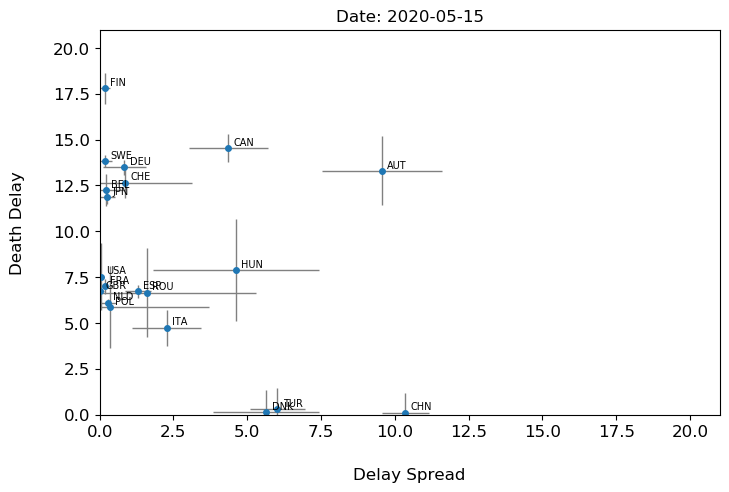

In [25]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))

# ax.scatter(modes_of_countries.death_fraction, modes_of_countries.death_delay)

ax.errorbar(modes_of_countries.delay_spread, modes_of_countries.death_delay, yerr=modes_of_countries.death_delay_std, xerr=modes_of_countries.delay_spread_std, 
    fmt="o", color="C0", ecolor="gray", alpha=1, lw=1, ms=4) #error_kw=Dict("ecolor"=>"gray", "lw"=>2, "capsize"=>5, "capthick"=>2)

for country in eachrow(modes_of_countries)
     ax.annotate(country.country_name, (country.delay_spread + 0.18, country.death_delay + 0.17), size=7)
end

ax.set_ylabel("Death Delay",  labelpad=20, size=12)
ax.set_xlabel("Delay Spread", labelpad=20, size=12)

ax.set_title("Date: $most_recent_update_date")

ax.set_ylim(0, 21)
ax.set_xlim(0, 21)

fig.savefig(PATH_1*"fig-10.pdf", bbox_inches = "tight")

# 3. Conclusions:

    - See MPP repository